In [1]:
import sys
!{sys.executable} -m pip install sklearn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load data from .txt files and make the train-test splits.
# Since we're working with text data, we need to vectorize the documents / turn each document
# into a point vector in a n-dimentions space. 
# Moreover, rather than simply using the word counts, we want to use the Term Frequency as feature value.

review_files = load_files('./cleaned_op_spam', encoding='latin-1')
x_train, x_test, y_train, y_test = train_test_split(review_files.data, review_files.target, test_size=0.2)

custom_stop_words = text.ENGLISH_STOP_WORDS.union(["\n"])
vectorizer = TfidfVectorizer(stop_words=custom_stop_words)
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
# print(x_trainvec.toarray())
# print(vectorizer.get_feature_names_out())

print('===== Target classes =====')
print(review_files.target_names)
# print(review_files)

===== Target classes =====
['negative deceptive', 'negative truthful', 'positive deceptive', 'positive truthful']


In [4]:
review_files

{'data': ['My stay at the Hotel Monaco Chicago was amazing. The staff are polite and well poised, eager to give a helping hand in a short notice. To someone like me, who had never even been in the city of Chicago, it really gave me a good feeling throughout my whole trip. The rooms, hallways and facilities were exceptionally clean and tidy, and whenver I went out, I would always find my room perfect ; be it for a night of undwinding after one of my conferences, or just to hit the mattress and sleep. During my stay, I stopped at their restuarant where I had one of the best American style meal in a while. Overall, the Hotel Monaco is a place I would surely stay at again if given the chance to visit Chicago for a second time. It is truely exceptional.\n',
  "For the price, you would think this would be a top quality hotel, but it was nowhere close. Service at check-in was slow and unfriendly. The room was even worse. It was small, dirty and smelled like stale cigarette smoke even though I

In [5]:
# word frequency for ALL corpuses
import pandas as pd
c_vectorizer = CountVectorizer(stop_words=custom_stop_words)
all_words = c_vectorizer.fit_transform(review_files.data)
counts = pd.DataFrame(all_words.toarray(), columns=c_vectorizer.get_feature_names_out())
sorted_counts = counts.sum().sort_values(ascending=False)
print(sorted_counts)

hotel        3337
room         2820
chicago      1527
stay         1304
great         865
             ... 
pointless       1
earning         1
poised          1
poisonous       1
kisses          1
Length: 9284, dtype: int64


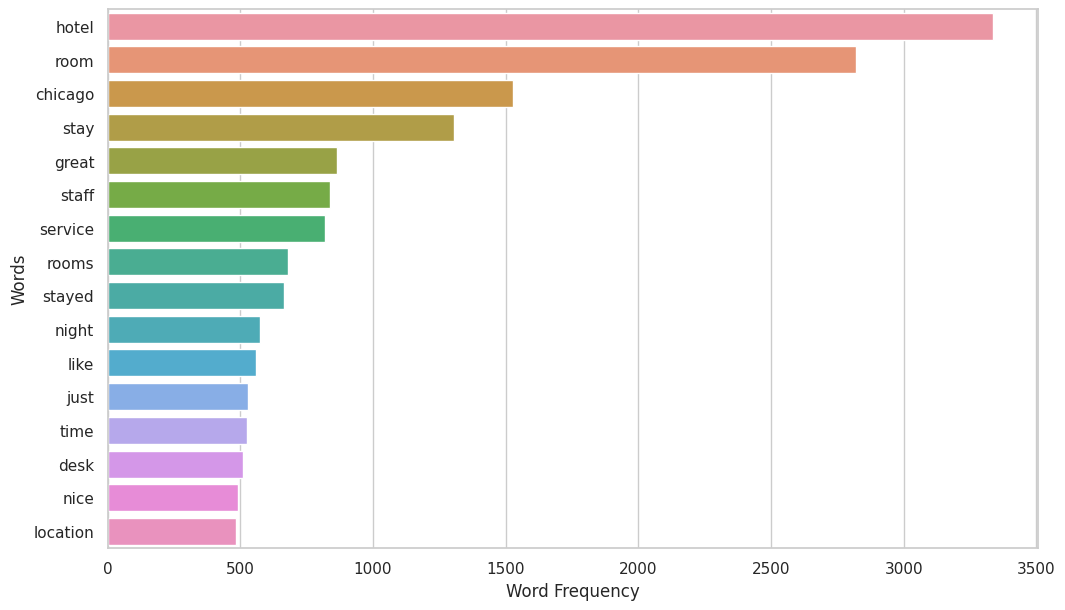

In [32]:
import seaborn as sns
limit = 16
custom_params = {'figure.figsize':(12,7)}
sns.set_theme(style="whitegrid", rc=custom_params)
ax = sns.barplot(y=sorted_counts.index[:limit], x=sorted_counts.values[:limit])
ax.set(xlabel='Word Frequency', ylabel='Words')
plt.show()

In [7]:
# Fit and test the models
mnb = MultinomialNB()
preds_mnb = mnb.fit(x_train_vec, y_train).predict(x_test_vec)
print("MNB correct predictions %d out of %d" % ((y_test == preds_mnb).sum(), x_test_vec.shape[0]))

loreg1 = LogisticRegression(solver='lbfgs')
preds_logreg1 = loreg1.fit(x_train_vec, y_train).predict(x_test_vec)
print("LReg-LBFGS correct predictions %d out of %d" % ((y_test == preds_logreg1).sum(), x_test_vec.shape[0]))

logreg2 = LogisticRegression(solver='liblinear')
preds_logreg2 = logreg2.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"LReg-Liblinear correct predictions {(y_test == preds_logreg2).sum()} out of {x_test_vec.shape[0]}")

logreg3 = LogisticRegression(solver='saga')
preds_logreg3 = logreg3.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"LReg-Saga correct predictions {(y_test == preds_logreg3).sum()} out of {x_test_vec.shape[0]}")

dectree = DecisionTreeClassifier()
preds_dectree = dectree.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"Decision Tree correct predictions {(y_test == preds_dectree).sum()} out of {x_test_vec.shape[0]}")

rforest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
preds_rforest = rforest.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"Random Forest correct predictions {(y_test == preds_rforest).sum()} out of {len(y_test)}")

MNB correct predictions 249 out of 320
LReg-LBFGS correct predictions 264 out of 320
LReg-Liblinear correct predictions 263 out of 320
LReg-Saga correct predictions 264 out of 320
Decision Tree correct predictions 164 out of 320
Random Forest correct predictions 189 out of 320


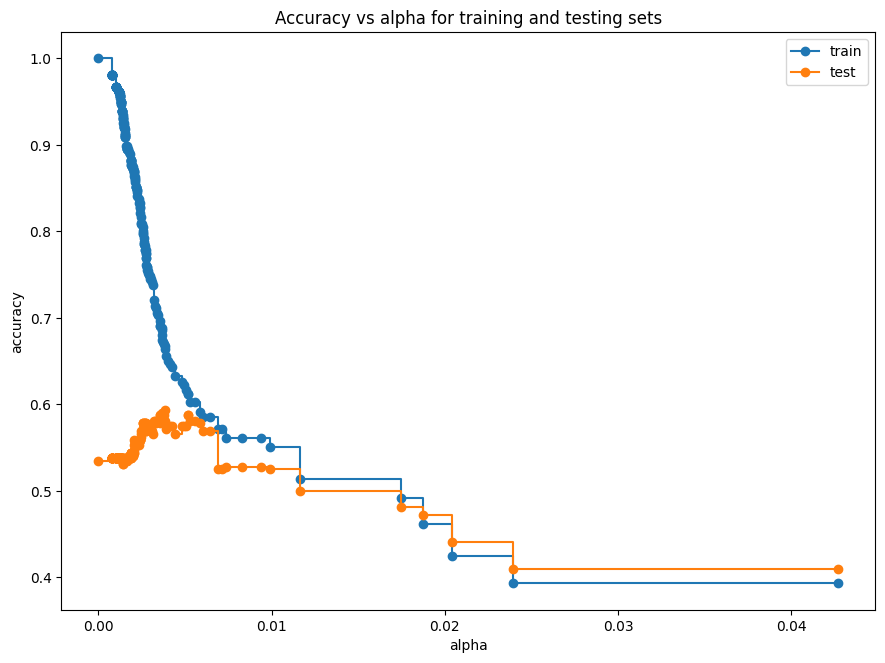

In [8]:
# Attempt to optimize the Decision Tree using Cost-Complexity Pruning technique
path = dectree.cost_complexity_pruning_path(x_train_vec, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# print(ccp_alphas)
# print(impurities)

dtrees = []
for ccp_alpha in ccp_alphas:
    dtr = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dtr.fit(x_train_vec, y_train)
    dtrees.append(dtr)
# print(f"Number of nodes in the last tree is: {dectrees[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

train_scores = [dtr.score(x_train_vec, y_train) for dtr in dtrees]
test_scores = [dtr.score(x_test_vec, y_test) for dtr in dtrees]

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7.5)
fig.set_dpi(100)
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# CONCLUSION: Accuracy optimizes at alpha 0.01. However, the score remains at ±52% so there is no noticeable 
# improvement achieved by the cost-complexity pruning, compared to the simple un-pruned tree.

In [9]:
# are these the most IMPORTANT words or just their frequency...?
# all probabilities are sorted
print(mnb.feature_log_prob_[:,:].argsort()[::-1])
np.set_printoptions(threshold=sys.maxsize)
print("All Feature Words:\n", vectorizer.get_feature_names_out())

range = 10
nd = mnb.feature_log_prob_[0, :].argsort()[::-1] # negative deceptive
print("\nNegative Deceptive:\n", np.take(vectorizer.get_feature_names_out(), nd[:range]))

nt = mnb.feature_log_prob_[1, :].argsort()[::-1] # negative truthful
print("Negative Truthful:\n", np.take(vectorizer.get_feature_names_out(), nt[:range]))

pd = mnb.feature_log_prob_[2, :].argsort()[::-1] # positive deceptive
print("Positive Deceptive:\n", np.take(vectorizer.get_feature_names_out(), pd[:range]))

pt = mnb.feature_log_prob_[3, :].argsort()[::-1] # positive truthful
print("Positive Truthful:\n", np.take(vectorizer.get_feature_names_out(), pt[:range]))

[[4190 4903 4902 ... 6290 3756 3438]
 [3375 3939 7439 ... 7081 1478 3756]
 [4190 2994 2995 ... 7081 3756 6290]
 [4190 4627 4626 ... 1478 3756 6290]]
All Feature Words:
 ['00' '000' '00a' '00am' '00pm' '03' '04' '05' '06' '07' '08' '0800' '09'
 '10' '100' '103' '104' '105' '105mph' '10am' '10pm' '10th' '10x' '11'
 '1112' '116' '11am' '11th' '12' '120' '122' '125' '127' '129' '12am'
 '12th' '13' '130' '130lb' '1334' '135' '139' '13th' '14' '140' '149'
 '14th' '15' '1500' '1508' '1519' '1546' '155' '159' '15mins' '15th' '16'
 '160' '1605' '160th' '1618' '165' '16th' '16thz' '17' '170' '173' '175'
 '1760' '179' '17th' '18' '180' '1802' '18th' '19' '1900' '1901' '191'
 '1920s' '1927' '1960' '1970s' '1992' '19th' '1am' '1or' '1pm' '1st' '20'
 '200' '2000' '2004' '2005' '2006' '2007' '2008' '2009' '200ish' '2010'
 '2011' '2012' '203' '20th' '20x' '21' '212' '214' '215' '217' '219' '22'
 '220' '22nd' '23' '23242' '23rd' '24' '240' '245' '249' '24hrs' '24th'
 '25' '250' '259' '25th' '26' '260' 

In [10]:
def run_cross_validation(nfolds, ngram=1):
    tf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(ngram, ngram))
    x_train_vec = tf_vectorizer.fit_transform(review_files.data)
    y_train_vec = review_files.target

    mnbayes = MultinomialNB()
    logreg = LogisticRegression(solver='lbfgs')
    logreg2 = LogisticRegression(solver='liblinear')
    logreg3 = LogisticRegression(solver='saga')
    dtree = DecisionTreeClassifier()
    ranForest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
    
    # Naive Bayes
    bayes_acc = cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    bayes_prec = 0 #cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    bayes_rec = 0 #cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    #Logistic regression
    lg_acc = cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    lg_prec = 0 #cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg_rec = 0 #cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    lg2_acc = cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    lg2_prec = 0 #cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg2_rec = 0 #cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    lg3_acc = cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    lg3_prec = 0 #cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg3_rec = 0 #cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
            
    dt_acc = cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    dt_prec = 0 #cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    dt_rec = 0 #cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    ranForest_acc = cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    ranForest_prec = 0 #cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    ranForest_rec = 0 #cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    print(f'         Model                         | Accuracy | Precision | Recall')
    print(f'Naive Bayes                            | {round(bayes_acc, 3)}    | {round(bayes_prec, 3)}    | {round(bayes_rec, 3)}')
    print(f'Logistic Regression - LBFGS solver     | {round(lg_acc, 3)}    | {round(lg_prec, 3)}    | {round(lg_rec, 3)}')
    print(f'Logistic Regression - Liblinear solver | {round(lg2_acc, 3)}    | {round(lg2_prec, 3)}    | {round(lg2_rec, 3)}')
    print(f'Logistic Regression - Saga solver      | {round(lg3_acc, 3)}    | {round(lg3_prec, 3)}    | {round(lg3_rec, 3)}')
    print(f'Decision Tree                          | {round(dt_acc, 3)}    | {round(dt_prec, 3)}    | {round(dt_rec, 3)}')
    print(f'Random Forest                          | {round(ranForest_acc, 3)}    | {round(ranForest_prec, 3)}    | {round(ranForest_rec, 3)}')

In [11]:
print('===== UNIGRAM, 5 folds cv =====')
run_cross_validation(nfolds=5, ngram=1)
print('===== UNIGRAM, 10 folds cv =====')
run_cross_validation(nfolds=10, ngram=1)
print('\n===== BIGRAM, 5 folds cv =====')
run_cross_validation(nfolds=5, ngram=2)
print('\n===== BIGRAM, 10 folds cv =====')
run_cross_validation(nfolds=10, ngram=2)

===== UNIGRAM, 5 folds cv =====
         Model                         | Accuracy | Precision | Recall
Naive Bayes                            | 0.791    | 0    | 0
Logistic Regression - LBFGS solver     | 0.817    | 0    | 0
Logistic Regression - Liblinear solver | 0.817    | 0    | 0
Logistic Regression - Saga solver      | 0.816    | 0    | 0
Decision Tree                          | 0.518    | 0    | 0
Random Forest                          | 0.593    | 0    | 0
===== UNIGRAM, 10 folds cv =====
         Model                         | Accuracy | Precision | Recall
Naive Bayes                            | 0.795    | 0    | 0
Logistic Regression - LBFGS solver     | 0.823    | 0    | 0
Logistic Regression - Liblinear solver | 0.816    | 0    | 0
Logistic Regression - Saga solver      | 0.821    | 0    | 0
Decision Tree                          | 0.523    | 0    | 0
Random Forest                          | 0.579    | 0    | 0

===== BIGRAM, 5 folds cv =====
         Model               